## Empirical Orthogonal Functions.

And now for something completely different.

Empirical Orthogonal Functions (EOF, for short) is a well-known and very much used method to analyse climate variability patterns. It's goal is to "find a new set of variables that capture most of the observed variance from the data through linear combinations of the original variables"$^{1}$, or even to "provide a compact description of the spatial and temporal variability of data series"$^{2}$.

There are two computationally different approaches to EOF calculation: (1) the Covariance Matrix, related to the solution of the standard Eigenvalue Problem, and (2) through the Singular Value Decomposition (SVD) method. The (1) is somewhat awkward to compute, while the (2) is usually regarded as the "right way"$^{3}$ to do what we want here. 

In [1]:
import cartopy.crs          as ccrs
import cartopy.feature      as cf
import cartopy              as cartopy
import matplotlib.pyplot    as plt
import matplotlib.gridspec  as gridspec
import numpy                as np
import pandas               as pd
import xarray               as xr
import scipy
import string

from cartopy.mpl.ticker     import LongitudeFormatter, LatitudeFormatter
from calendar               import month_name
from scipy.signal           import detrend
from functions              import*
from scipy.stats            import pearsonr

In [2]:
dset  =  xr.open_dataset('pacific_asst_1951_2015.nc')
sst   =  dset['sst'][:,:,:]
lat   =  dset['lat'][:]
lon   =  dset['lon'][:]

Our input anomaly matrix will be the ASST dataset for the Tropical Pacific we are already used to. For our luck, through SVD we don't have to define a Covariance Matrix as our input ASST is enough.

It is convenient to perform a weighting by the square root of the cosine of our latitude array prior to the SVD computing$^{4}$. 

In [3]:
lat_v  = np.asarray(sst['lat'])[...,np.newaxis]
coslat = np.cos(np.deg2rad(lat_v))
wgts   = np.sqrt(coslat)

sst = sst * wgts # weighted ASST

In [4]:
##--- month selecting (optional)
djf  =  sst.sel(time=np.in1d(sst['time.month'], [1,2,12]))

##--- some useful numpy arrays 
tseason  =  np.asarray(djf['time'])  # months array
p_lat    =  np.asarray(djf['lat'])   # latitude array
p_lon    =  np.asarray(djf['lon'])   # longitude array
time     =  len(tseason)             # time array 

As you can see we defined our ASST values to get the DJF months, to keep pace with our [correlation](http://nbviewer.jupyter.org/github/willyhagi/climate-statistics/blob/master/Jupyter-Notebooks/correl.ipynb) and [composite](http://nbviewer.jupyter.org/github/willyhagi/climate-statistics/blob/master/Jupyter-Notebooks/composites.ipynb) fields.

It's good to pay some attention to the matrix dimensions during our calculations, remembering the fact that SVD is a tool from linear algebra.

In [5]:
print (djf.shape)

(195, 31, 96)


That is, our djf asst matrix has (time, lat, lon) dimensions. Now we must reshape it and define what is usually called the "S-Mode" input matrix. 

In [6]:
##--- pre-processing of anomaly matrix

# masking to use detrend function
asst_nan   =  Nan_calc(djf, tseason, lat, lon) # Nan_calc class
asst_res   =  asst_nan.reshaping()
val, asst_masked   =  asst_nan.masking_array()

print (asst_masked.shape)

(195, 2632)


Our old asst matrix is has now (time, lat x lon) dimensions. The S-Mode is sometimes defined as the transpose of this matrix, sometimes as shown above. People don't seem to have much consensus on what it should be, but this is merely a notation issue. 

In [7]:
# linear detrending
asstdt   =  detrend(asst_masked, type='linear') 

# normalization of s-mode input matrix
F_matrix  =  asstdt / np.std(asstdt, axis=0)    

time       =  len(F_matrix[0:,0])
grid_mask  =  len(F_matrix[0,0:])

It is good to detrend your data but not necessary to normalize it as we did above (you should do it, anyway).

In [8]:
##--- EOF with SVD
def eof_svd(F):
    U, g, V  =  np.linalg.svd(F, full_matrices=False)
    U        =  np.real(U)            # left singular vectors
    g        =  np.real(g)            # singular values
    V        =  np.real(V)            # right singular vectors
    #
    lmbd     =  g **2.                # eigenvalues
    PC       =  np.dot(np.diag(g), U) # principal components
    EOF      =  np.dot(V.transpose(), PC)         # EOF projection
    return U, V, g, lmbd, PC.transpose(), EOF

In [9]:
U, V, g, lmbd, PC, EOF  =  eof_svd(F_matrix)

The SVD decomposes our input matrix (let's call it F, where F(N,M)) into three others:

$ F = U \times \Gamma \times V^{t} $ 

U(N,N) gives our left singular vectors, similar to the eigenvectors of the traditional Eigenvalue Problem solution, $\Gamma$(M,N) has scalars $\gamma_{k}$ where $\gamma_{k}^{2}$ are our eigenvalues, and $V^{t}$(N,M) gives our right singular vectors.

In [10]:
print ("U(N,N)",U.shape)

U(N,N) (195, 195)


In [11]:
print ("V(N,M)", V.shape)

V(N,M) (195, 2632)


A cautionary note: $V^{t}$ is mathematically defined as having (M,M) dimensions. However, due to our [NumPy calculation](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html) where the argument for 'full_matrices' is FALSE, the matrix is returned with the dimensions above.

The 'lmbd' matrix is being returned as a column vector with the eigenvalues calculated from the $\Gamma$ matrix.

Finally, our EOF modes are defined as:

$$F = \sum_{n=1}^{N} U^{n} \gamma^{n} V^{nt} $$

n=1 is the first mode, n=2 the second and so on.

The Principal Components (PCs) are:

$ PC^{n} = \gamma^{n} V^{nt} $ 

The amount of explained variance for each mode (very important) is:

$ \% var = \frac{\gamma^{n}}{\sum_{n=1}^{N} \gamma^{n}} \times 100 $

(sorry if this is getting kinda painful and not fun enough)

The EOF fields and PCs can and should be normalized. Check the references down below for details or things will get kinda mathy here.

In [12]:
##--- EOF and PC normalization
def eof_norm(PC, V, lmbd):
    PCnor   =  PC / np.sqrt(lmbd)
    EOFnor  =  V * np.sqrt(lmbd)
    return PCnor, EOFnor

In [13]:
PCn, EOFn  =  eof_norm(PC, V.transpose(), lmbd)

In [14]:
#--- matrix reconstructions
EOF_rec  =  rec_matrix(EOFn.transpose(), tseason, p_lat, p_lon, val)


#----- amount of explained variance
var_exp = []
for i in range(1,len(np.arange(1,time+2,1)),1):
    var_exp.append((lmbd[i-1] / np.sum(lmbd)) * 100.)

var_exp = np.around(var_exp,decimals=2)

Now that everything is calculated, let us first plot our Eigenvalue Spectrum.

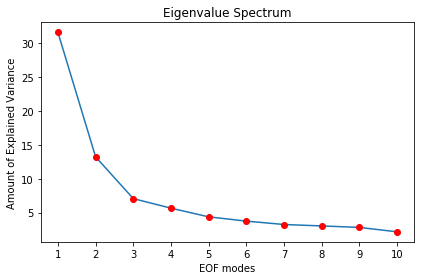

In [16]:
n      =  len(tseason)
dt     =  (1/3)
time   =  (np.arange(n))*dt + 1951.0  

var_t  = np.arange(1, len(tseason)+1, 1)



plt.plot(var_t[0:10], var_exp[0:10])
plt.plot(var_t[0:10], var_exp[0:10], 'ro')
plt.title('Eigenvalue Spectrum')
plt.ylabel('Amount of Explained Variance')
plt.xlabel('EOF modes')
plt.xticks(range(1, 11, 1))

plt.tight_layout()
plt.show()

That means: the first EOF contains a little more than 30% of the explained variance, the second almost 15% and so on. This spectrum can be improved with the North et al (1982) Rule of Thumb, but the separation between the EOF modes are looking clear enough.

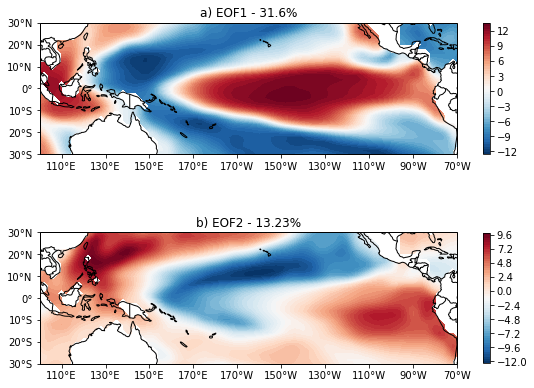

In [17]:
proj      =  ccrs.PlateCarree(central_longitude=180.)
proj2     =  ccrs.PlateCarree()


fig, axes = plt.subplots(figsize=(8,6),nrows = 2, ncols = 1,
                         subplot_kw={'projection': proj})
axes = axes.flatten()


for i, month in enumerate(range(1,3,1)):
    ax = axes[i]
    ax.add_feature(cf.BORDERS,zorder=2,edgecolor='k')           
    ax.add_feature(cartopy.feature.COASTLINE)                   
#    ax.add_feature(cf.LAND,color='grey')                      
    y_lats  = np.arange(-40,40,10)
    x_lons  = np.arange(-70,360,20)
    tick_fs = 16
    lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                       number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xticks(x_lons, minor=False, crs=proj)
    ax.set_yticks(y_lats, minor=False, crs=proj)
    ax.set_title('%s) EOF%s - %s%%' %(string.ascii_lowercase[i], i+1,var_exp[i])) # var_exp[i]
    data = ax.contourf(lon,lat,EOF_rec[i,:,:],
                       60,
                       transform = proj2,
                       cmap = 'RdBu_r')
    fig.colorbar(data, ax=ax, shrink=0.65)

plt.tight_layout()
plt.show()

Finally, our EOF modes! The First mode (the dominant one) really looks like our now familiar ENSO pattern, while the second is a little bit different. You can compare these modes with the ones found by Ashok et al (2007) analysis for the Tropical Pacific, they are very similar. 

Now, time for our Principal Components associated with the EOF fields above.

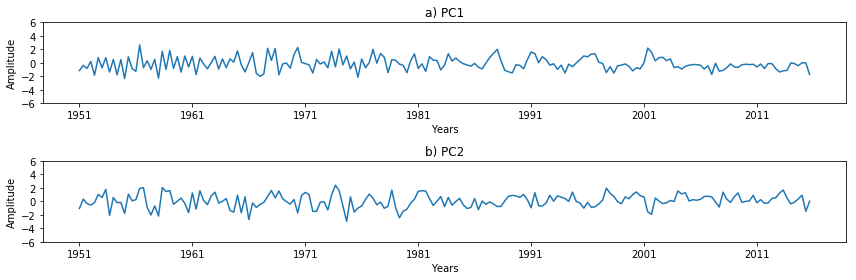

In [19]:
fig2, axes2 = plt.subplots(figsize=(12,4),nrows = 2, ncols = 1)
axes2 = axes2.flatten()

for i in range(1,3,1):
    ax2 = axes2[i-1]
    ax2.plot(time, PCn[:, i-1] / np.std(PCn[:, i-1]))
    ax2.set_xticks(range(1951, 2016, 10))
    ax2.set_yticks(range(-6,7,2))
    ax2.set_ylabel('Amplitude')
    ax2.set_xlabel('Years')
    ax2.set_title('%s) PC%s' %(string.ascii_lowercase[i-1],i))

plt.tight_layout()
plt.show()

Another way to show the EOF fields above is through correlations between each Principal Component and the input ASST time series. Have in mind, however, that we would have to consider the issues covered before (statistical significance and such things). 

The are lots of variations from the EOF calculations we saw, such as Rotated EOF (REOF), Extended EOF (EEOF) and many others. A nice review was made by Hannachi et al (2004) and you should check it.

By the way, since nothing is perfect, the EOF method has some limitations and problems to consider, but our lesson is done for now. 

Feel free to check and use the [eofs](http://ajdawson.github.io/eofs/) package if you want; it might save you lots of lines of code, but our way here works just fine as well (at least I hope so).

## REFERENCES

1 - Hannachi, A. "A primer for EOF analysis of climate data." Department of Meteorology, University of Reading (2004): 1-33.

2 - Venegas, Silvia A. "Statistical methods for signal detection in climate." Danish Center for Earth System Science Report 2 (2001): 96.

3 - Navarra, Antonio, and Valeria Simoncini. A guide to empirical orthogonal functions for climate data analysis. Springer Science & Business Media, 2010.

4 - Chung, Chul, and Sumant Nigam. "Weighting of geophysical data in principal component analysis." Journal of Geophysical Research: Atmospheres 104.D14 (1999): 16925-16928.

5 - North, Gerald R., et al. "Sampling errors in the estimation of empirical orthogonal functions." Monthly Weather Review 110.7 (1982): 699-706.

6 - Ashok, Karumuri, et al. "El Niño Modoki and its possible teleconnection." Journal of Geophysical Research: Oceans 112.C11 (2007).